# Trabajo Final - Econometría Espacial
## Propuesta de investigación: análisis espacial del discurso de los senadores nacionales durante la sesión extraordinaria en la que se debatía la interrupción voluntaria del embarazo
### Parte 2 del trabajo:
Ubicación de los senadores dentro del espectro político utilizando componentes princiaples a partir de las votaciones pasadas.

In [3]:
# Paquetes:
from IPython.core.display import HTML
import requests
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import datetime
import seaborn as sns
from dateutil import parser
import pytz
import pylab as pl
# %pip install pyquery
from pyquery import PyQuery as pq
import numpy as np
import scipy
import pandas as pd
from lxml import etree
import os
from os import path
from pprint import pprint
import dateutil
import json
%matplotlib inline

In [77]:
# Este bloque de código va cambiando el número del final de la URL y va extrayendo la data
# URL: http://votaciones.lanacion.com.ar/api/votacion/637
# Tarda 5 minutos aprox

all_motions_json = []
# for i in range(1, 637+1):
for i in range(1, 998+1):
    try:
        j = json.load(open('jsons/%s.json' % i))
        all_motions_json.append(j)
    except:
        pass

In [78]:
j['fecha']
# '01/07/2016'

'01/07/2016'

In [79]:
s_votes = []

for m in all_motions_json:
    v = m['votos']
    s = pd.DataFrame(v)
    s['sesion_id'] = m['sesion_id']
    s['datestr'] = m['fecha']
    s = s.set_index(['legislador_id', 'sesion_id'])
    s_votes.append(s)

In [80]:
df_votes = pd.concat(s_votes)

In [81]:
# Este bloque de código asigna a cada voto (string) un valor
def vote_to_number(v):
    MAPPING = {
        'AFIRMATIVO': 1, # Yes
        'AUSENTE': 0, # Absent, did not come to the session
        'NEGATIVO': -1, # No
        'ABSTENCION': 0, # person is present, but not vote
    }
    return MAPPING.get(v, 0)
    
df_votes['vote-value'] = df_votes['voto'].apply(vote_to_number)

In [82]:
from datetime import date

df_votes['date'] = df_votes['datestr'].apply(lambda x: date(
        int(x.split('/')[2]), 
        int(x.split('/')[1]), 
        int(x.split('/')[0])
    ))
df_votes['datetime'] = df_votes['date'].apply(lambda d: datetime.datetime(*d.timetuple()[:7]))

In [83]:
df_votes['date']
#10/12/2013 - 10/12/2015

# 2013-04-17 - 2016-07-01

legislador_id  sesion_id
288            8            2013-04-17
395            8            2013-04-17
401            8            2013-04-17
403            8            2013-04-17
404            8            2013-04-17
                               ...    
778            637          2016-07-01
889            637          2016-07-01
156            637          2016-07-01
776            637          2016-07-01
679            637          2016-07-01
Name: date, Length: 93330, dtype: object

In [11]:
s = df_votes['partido'].value_counts()
df_party_counts = pd.DataFrame(df_votes['partido'].value_counts()).reset_index()
df_party_counts.columns = ['party', 'count']
df_party_counts.to_csv('data/party-count.csv')

In [12]:
# Vemos el data frame
df_votes

,,provincia_id,provincia,mail,partido,photo,twitter,agrupacion,in_ranking,tag_nacion,voto,...,nombre,descripcion,agrupacion_id,camara,presidencia,agrupacion_color,datestr,vote-value,date,datetime
legislador_id,sesion_id,,,,,,,,,,,,,,,,,,,,,
288,8,20,LA RIOJA,gherrera@diputados.gob.ar,FRENTE PARA LA VICTORIA,/media/photos/Herrera-Griselda-Noemi.jpg,@griherreraok,Kirchnerismo y aliados,1,,AFIRMATIVO,...,"HERRERA, Griselda Noemí",,3,diputados,False,#007caf,17/04/2013,1,2013-04-17,2013-04-17 00:00:00.000002
395,8,4,BUENOS AIRES,cmoreno@diputados.gob.ar,FRENTE PARA LA VICTORIA,/media/photos/Moreno_Carlos_julio.jpg,@julioc_moreno,Kirchnerismo y aliados,1,,AFIRMATIVO,...,"MORENO, Carlos Julio",,3,diputados,False,#007caf,17/04/2013,1,2013-04-17,2013-04-17 00:00:00.000002
401,8,4,BUENOS AIRES,,FRENTE PARA LA VICTORIA,/media/,,,1,,AFIRMATIVO,...,"MULLER, Mabel Hilda",,,diputados,False,,17/04/2013,1,2013-04-17,2013-04-17 00:00:00.000002
403,8,1,SANTIAGO DEL ESTERO,gnavarro@diputados.gob.ar,FRENTE CÍVICO POR SANTIAGO,/media/photos/Navarro_Graciela.jpg,,Kirchnerismo y aliados,1,,AFIRMATIVO,...,"NAVARRO, Graciela",,3,diputados,False,#007caf,17/04/2013,1,2013-04-17,2013-04-17 00:00:00.000002
404,8,8,CÓRDOBA,,FRENTE PARA LA VICTORIA,/media/,,,1,,AFIRMATIVO,...,"NEBREDA, Carmen Rosa",,,diputados,False,,17/04/2013,1,2013-04-17,2013-04-17 00:00:00.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,637,12,SALTA,jdavid@diputados.gob.ar,JUSTICIALISTA,/media/photos/David_Nestor.jpg,,PJ no K,1,,AUSENTE,...,"David., Néstor Javier",,12,diputados,False,#A05F11,01/07/2016,0,2016-07-01,2016-07-01 00:00:00.000004
889,637,2,MENDOZA,gcousinet@diputados.gob.ar,LIBRES DEL SUR,/media/,@GCousinet,FAP,1,,AUSENTE,...,"Cousinet., Graciela",,11,diputados,False,#CECA7A,01/07/2016,0,2016-07-01,2016-07-01 00:00:00.000004
156,637,18,SANTA CRUZ,ecosta@diputados.gob.ar,UNIÓN CÍVICA RADICAL,/media/photos/Costa_Eduardo_1.jpg,@eduardocostasc,Cambiemos,1,,AUSENTE,...,"COSTA, Eduardo Raúl",,10,diputados,False,#FEDB30,01/07/2016,0,2016-07-01,2016-07-01 00:00:00.000004


In [13]:
print('Total number of sessions:')
print(len(df_votes.reset_index()['sesion_id'].value_counts()))

Total number of sessions:
371


In [14]:
print('Total number of legislators:')
print(len(df_votes.reset_index()['legislador_id'].value_counts()))

Total number of legislators:
648


In [15]:
len(df_votes)

93330

In [16]:
df_votes.to_csv('data/votes.csv')

In [17]:
df_member_profile = df_votes.reset_index()[['legislador_id', 'agrupacion', 'agrupacion_color', 'camara', 'mail', 'nombre', 'partido']].drop_duplicates()
print(len(df_member_profile))
df_member_profile = df_member_profile.drop_duplicates('legislador_id')
print(len(df_member_profile))
df_member_profile.to_csv('data/member-profile.csv')

1131
648


In [18]:
df_member_profile[
    df_member_profile['legislador_id'] == 738
]

,legislador_id,agrupacion,agrupacion_color,camara,mail,nombre,partido
48160,738,Massismo y aliados,#b185b7,diputados,mtundis@diputados.gob.ar,"TUNDIS, MIRTA",FRENTE RENOVADOR


In [21]:
df_member_profile.set_index('legislador_id').ix[738]

AttributeError: 'DataFrame' object has no attribute 'ix'

In [22]:
df_selected_votes = df_votes[
    (df_votes['date'] >= date(2013, 12, 12))
    &
    (df_votes['date'] <= date(2015, 12, 12))
]

In [23]:
len(df_selected_votes)

37379

In [24]:
df_votes_brief = df_selected_votes[['voto', 'vote-value']]

In [25]:
df_votes_brief['voto'].value_counts()

AFIRMATIVO    25638
AUSENTE        7516
NEGATIVO       3241
ABSTENCION      984
Name: voto, dtype: int64

In [26]:
df_matrix = df_votes_brief.reset_index().pivot(index='legislador_id', columns='sesion_id', values='vote-value')

In [27]:
df_matrix = df_matrix.fillna(0)

In [28]:
df_matrix.to_csv('data/matrix-2013-2015.csv')

In [29]:
df_matrix.shape

(264, 146)

In [45]:
# X = np.matrix(df_matrix.fillna(0).as_matrix()).astype('int8')
# X = np.matrix.astype('int8')
# X = np.matrix
X = np.matrix(df_matrix.fillna(0).astype('int8'))

#### Componentes princiaples

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)
df_pc = pd.DataFrame(X_reduced, index=df_matrix.index, columns=['PC1', 'PC2', 'PC3'])

In [47]:
pca.explained_variance_

array([28.33727497,  3.63767599,  1.95871994])

Watch out:
* The explained variance by PC1 to PC3 is very small in this data set
* The data set is highly non-linear

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

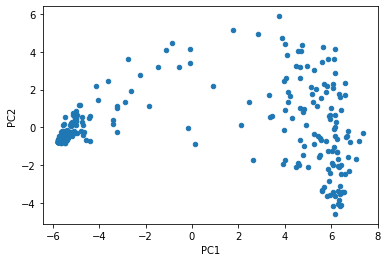

In [48]:
%matplotlib inline
df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

In [49]:
df_party_count_color = pd.read_csv('data/party-count-color.csv')

In [50]:
len(df_pc)

264

In [51]:
len(df_member_profile)

648

In [52]:
df_pc_member = pd.merge(df_pc.reset_index(), df_member_profile, how='left',
                        left_on='legislador_id', right_on='legislador_id')

In [53]:
len(df_pc_member)

264

In [54]:
len(df_pc)

264

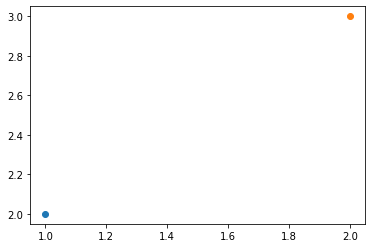

In [55]:
plt.scatter(1, 2)
plt.scatter(2, 3)

('', '')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#007caf')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('Peronismo no kirchnerista', '#f6a619')
('Pro y aliados', '#fbd95b')
('UNEN - FAP - UCR', '#8eab35')


Text(0, 0.5, 'PC2')

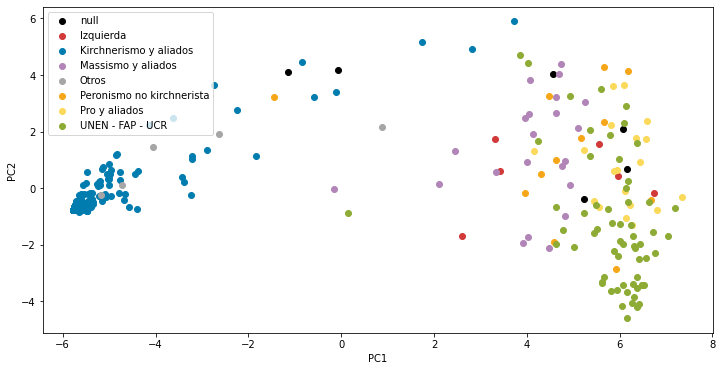

In [56]:
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1)
from matplotlib.colors import ColorConverter

'''
for (i, m) in df_pc_member.iterrows():
    #print(m['PC1'])
    ax.scatter(m['PC1'], m['PC2'], color=m['_color'])
    #print(m)
'''

for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], group['PC2'], color=gname[1], label=gname[0])

plt.legend(loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC2')

#df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

('', '')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#007caf')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('Peronismo no kirchnerista', '#f6a619')
('Pro y aliados', '#fbd95b')
('UNEN - FAP - UCR', '#8eab35')


Text(0, 0.5, 'PC2')

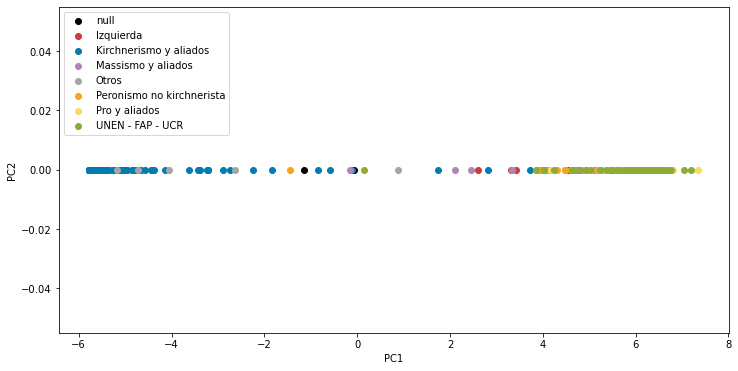

In [57]:
%matplotlib inline

plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1)
from matplotlib.colors import ColorConverter

'''
for (i, m) in df_pc_member.iterrows():
    #print(m['PC1'])
    ax.scatter(m['PC1'], m['PC2'], color=m['_color'])
    #print(m)
'''

for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], [0] * len(group['PC1']), color=gname[1], label=gname[0])

plt.legend(loc='upper left')
plt.xlabel('PC1')
plt.ylabel('PC2')

#df_pc[['PC1', 'PC2']].plot(x='PC1', y='PC2', kind='scatter')

In [58]:
df_pc_member['legislador_id'] = df_pc_member['legislador_id'].apply(lambda x: str(x))
open('data/pc-member-3d.json', 'w').write(json.dumps(
    df_pc_member.set_index('legislador_id').T.to_dict()
    ))

78005

In [59]:
df_pc_member

,legislador_id,PC1,PC2,PC3,agrupacion,agrupacion_color,camara,mail,nombre,partido
0,1,-0.581584,3.205870,-0.160135,Kirchnerismo y aliados,#007caf,diputados,nabdaladem@diputados.gob.ar,"Abdala de Matarazzo, Norma Amanda",FRENTE CÍVICO POR SANTIAGO
1,8,5.984325,1.039177,-1.520055,UNEN - FAP - UCR,#8eab35,diputados,oaguad@diputados.gob.ar,"Aguad, Oscar Raúl",UNIÓN CÍVICA RADICAL
2,10,3.960056,-0.156964,0.767200,Peronismo no kirchnerista,#f6a619,diputados,laguilar@diputados.gob.ar,"AGUILAR, Lino Walter",FRENTE PERONISTA
3,19,5.452833,-1.578642,-0.600426,UNEN - FAP - UCR,#8eab35,diputados,ralfonsin@diputados.gob.ar,"ALFONSÍN, Ricardo Luis",UNIÓN CÍVICA RADICAL
4,22,6.595750,2.366079,2.555453,Pro y aliados,#fbd95b,diputados,lalonso@diputados.gob.ar,"ALONSO, Laura",PRO
...,...,...,...,...,...,...,...,...,...,...
259,765,5.848482,3.602665,0.836548,Pro y aliados,#fbd95b,diputados,,"Laspina, Luciano",UNIÓN PRO
260,766,-0.068917,4.161108,-2.417735,,,diputados,,"Pasini, Ariel Osvaldo Eloy",FRENTE PARA LA VICTORIA
261,767,4.568847,4.037804,-1.684544,,,diputados,,"Bregman, Myriam",PTS - FRENTE DE IZQUIERDA
262,768,4.019398,4.417477,-1.775098,UNEN - FAP - UCR,#8eab35,diputados,,"Fernández Blanco, MarÍA Cristina",UNIÓN CÍVICA RADICAL


('', '')
('Izquierda', '#D23939')
('Kirchnerismo y aliados', '#007caf')
('Massismo y aliados', '#b185b7')
('Otros', '#A6A6A6')
('Peronismo no kirchnerista', '#f6a619')
('Pro y aliados', '#fbd95b')
('UNEN - FAP - UCR', '#8eab35')


8

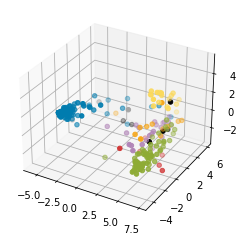

In [60]:
%matplotlib inline

x = np.array(X_reduced.T[0, :]).astype('float')
y = np.array(X_reduced.T[1, :]).astype('float')
z = np.array(X_reduced.T[2, :]).astype('float')

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for (gname, group) in df_pc_member.groupby(['agrupacion', 'agrupacion_color']):
    print(gname)
    if gname == ('', ''):
        gname = ('null', '#000000')
    ax.scatter(group['PC1'], group['PC2'], group['PC3'], color=gname[1], label=gname[0])
#ax.scatter(x, y, z, picker=True, s=100)

def onpick(X_3D, event):
    #print(event)
    if hasattr(onpick, '_label'):
        #pass
        onpick._label.remove()
    thisline = event.artist
    ind = event.ind
    #print(type(ind))
    #print(X_3D[0, ind])
    names = df_matrix.iloc[ind].index.values
    #print(names)
    label = ('\n'.join(names))
    pos = (X_3D[0, ind[0]], X_3D[1, ind[0]], X_3D[2, ind[0]])
    #onpick._label = ax.set_title(label
    onpick._label = ax.text(*pos, s=label)
    fig.canvas.draw()
    
fig.canvas.mpl_connect('pick_event', lambda e: onpick(X_reduced.T, e))